# NLP HW3: Movie Review Sentiment Analysis

*by Alexander Marinskiy*

## Task
1. Choose and argue your measure of a test's accuracy.
2. Build data processing and classification pipeline; Please compare word-embeddings vs classical methods 
3. Tune your model;

In [1]:
import pandas as pd

import numpy as np
from numpy import array
from numpy import asarray
from numpy import zeros

from matplotlib import pyplot as plt
import seaborn as sns

import warnings

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense, Dropout, Flatten, Embedding, LSTM
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [2]:
# ignore warnings
warnings.filterwarnings("ignore")

## 1. EDA

In [3]:
# read data
train = pd.read_csv('dataset/train.tsv', sep="\t")
test = pd.read_csv('dataset/test.tsv', sep="\t")
sub = pd.read_csv('dataset/sampleSubmission.csv', sep=",")

In [4]:
# check what dataset looks like
train.head(n=10)

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
5,6,1,of escapades demonstrating the adage that what...,2
6,7,1,of,2
7,8,1,escapades demonstrating the adage that what is...,2
8,9,1,escapades,2
9,10,1,demonstrating the adage that what is good for ...,2


In [5]:
print('There are', train.shape[0], 'rows and', train.shape[1], 'columns in our dataset')

There are 156060 rows and 4 columns in our dataset


In [6]:
# let's check the distribution of labels in dataset
train["Sentiment"].value_counts()

2    79582
3    32927
1    27273
4     9206
0     7072
Name: Sentiment, dtype: int64

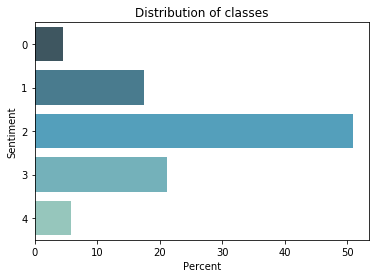

In [7]:
# visualizing the distribution
ax = sns.barplot(x="Sentiment", 
                 y="Sentiment", 
                 data=train, 
                 estimator=lambda x: len(x) / len(train) * 100, palette="GnBu_d", 
                 orient='h')
ax.set(xlabel="Percent", title='Distribution of classes')
plt.show()

The sentiment labels are:

- 0 - negative
- 1 - somewhat negative
- 2 - neutral
- 3 - somewhat positive
- 4 - positive

We see that more than 50% of the phrases in the dataset are neutral. Also, the number of somewhat positive phrases is approximately equal to the number of somewhat negative ones, and the number of positive ones is approximately equal to the number of negative ones.

## 2. Choosing metric for quality

This kaggle competition is evaluated on classification accuracy (the percent of labels that are predicted correctly). Since this is how the final result will be defined, there are no real reason to use different metric for quality. Therefore, I will use accuracy. 

## 3. Classical models

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

In [9]:
# make dictionary with names of vectorizers and vectorizers
vecrotizers={'Tf-idf vectorizer': TfidfVectorizer(sublinear_tf=True, 
                                                  min_df=5, 
                                                  norm='l2', 
                                                  encoding='latin-1', 
                                                  ngram_range=(1, 2), 
                                                  stop_words='english'),
             'Count vectorizer': CountVectorizer(min_df=5, 
                                                 encoding='latin-1', 
                                                 stop_words='english', 
                                                 ngram_range=(1, 2))}

In [10]:
# create dictionary with models
models = {'Multinomial Naive Bayes': MultinomialNB(),
          'Logistic Regression': LogisticRegression(random_state=42)}

In [11]:
# Function to get scores for specific vectorizer and model. 
def evaluate_model(X, y, vectorizer_name, vectorizer, model_name, model):
    # create pipline to fit vectorizer on each fold
    clf = make_pipeline(vectorizer, model)
    
    # get scores
    scores = cross_validate(clf, 
                            X, 
                            y, 
                            scoring=['accuracy'], 
                            cv=5)
    
    # print results
    print('Accuracy for', model_name, 'model with', vectorizer_name, 'on cross-validation is', np.mean(scores['test_accuracy']))

In [12]:
for model_name, model in models.items():
    for vectorizer_name, vectorizer in vecrotizers.items():
        evaluate_model(train.Phrase, train.Sentiment, vectorizer_name, vectorizer, model_name, model)

Accuracy for Multinomial Naive Bayes model with Tf-idf vectorizer on cross-validation is 0.5399076228786248
Accuracy for Multinomial Naive Bayes model with Count vectorizer on cross-validation is 0.5523515243763759
Accuracy for Logistic Regression model with Tf-idf vectorizer on cross-validation is 0.5778738303431306
Accuracy for Logistic Regression model with Count vectorizer on cross-validation is 0.5760732748979114


## 4. Word Embedings

### Prepare vectors

For word embeddings approach I'm going to use pre-trained GloVe model (GloVe 6B): https://nlp.stanford.edu/projects/glove/

In [13]:
# define documents
docs = train.Phrase

# define class labels
labels = pd.get_dummies(train.Sentiment)

In [14]:
# prepare tokenizer
t = Tokenizer()
t.fit_on_texts(docs)
vocab_size = len(t.word_index) + 1
print('The size of vocabulary is', vocab_size)

The size of vocabulary is 15289


In [15]:
# integer encode the documents
encoded_docs = t.texts_to_sequences(docs)
print('Example of encoded document:')
print(encoded_docs[0])

Example of encoded document:
[2, 323, 3, 14150, 6028, 1, 6586, 9, 52, 8, 46, 13, 1, 2976, 8, 177, 46, 13, 1, 10913, 65, 3, 78, 668, 10117, 19, 576, 3, 78, 2123, 5, 57, 3, 2, 42]


In [16]:
# pad documents 
max_length = max(len(doc) for doc in encoded_docs)
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
print('Example of padded document:')
print(padded_docs[0])

Example of padded document:
[    2   323     3 14150  6028     1  6586     9    52     8    46    13
     1  2976     8   177    46    13     1 10913    65     3    78   668
 10117    19   576     3    78  2123     5    57     3     2    42     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0]


In [17]:
# load the whole embedding into memory
embeddings_index = dict()
f = open('glove.6B/glove.6B.100d.txt', encoding="utf8")
for line in f:
        values = line.split()
        word = values[0]
        coefs = asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [21]:
# create a weight matrix for words in training docs
embedding_matrix = zeros((vocab_size, 100))

for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Now lets prepare training and test sample:

In [18]:
# prepare train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(padded_docs, labels, test_size=0.05, random_state=42)

### Simple 3 layers neural network with dropout

In [22]:
# define model
model = Sequential()
model.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=max_length, trainable=False))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

# compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [23]:
# summarize the model
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 49, 100)           1528900   
_________________________________________________________________
flatten_1 (Flatten)          (None, 4900)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              5018624   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 5125      
Total para

In [ ]:
# set checkpoint
filepath="simple-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max', save_weights_only=False)

In [ ]:
# fit the model
model.fit(X_train, 
          y_train, 
          epochs=50, 
          verbose=1, 
          validation_data=(X_test, y_test),
          callbacks=[checkpoint])

In [24]:
# load model
model = load_model('simple-45-0.61.hdf5')

# evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print('Accuracy simple 3 layer neural network: %f' % (accuracy*100))

Instructions for updating:
Use tf.cast instead.
7803/7803 [==============================] - 4s 537us/step
Accuracy simple 3 layer neural network: 61.245675


### LSTM model

In [ ]:
model_lstm=Sequential()
model_lstm.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=max_length, trainable=False)
model_lstm.add(LSTM(64,dropout=0.4, recurrent_dropout=0.4,return_sequences=True))
model_lstm.add(LSTM(32,dropout=0.5, recurrent_dropout=0.5,return_sequences=False))
model_lstm.add(Dense(5,activation='softmax'))
model_lstm.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model_lstm.summary()

In [ ]:
# set checkpoint
filepath="lstm-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max', save_weights_only=False)

In [ ]:
model_lstm.fit(X_train, 
          y_train, 
          epochs=50, 
          verbose=1, 
          validation_data=(X_test, y_test),
          callbacks=[checkpoint])

In [26]:
# load model
model_lstm = load_model('lstm-06-0.62.hdf5')

# evaluate the model
loss, accuracy = model_lstm.evaluate(X_test, y_test, verbose=1)
print('Accuracy of LSTM model: %f' % (accuracy*100))

7803/7803 [==============================] - 7s 941us/step
Accuracy of LSTM model: 62.386262


I stopped the training early because the deadline was close. It seems that LSTM can show even better results.

## 5. Results

We see that models based on Word Embeddings show noticeably better quality on this task.

* Out of the classical models, Logic regression with tf-idf vectorizer showed the best quality. 
* Out of the depth learning models, the LSTM model had the best accuracy.